In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
from collections import Counter


In [2]:
IMG_SIZE = (300, 300)        # EfficientNet-B3 standard
BATCH_SIZE = 8               # Safe for 8GB RAM
EPOCHS_STAGE1 = 15
EPOCHS_STAGE2 = 30

TRAIN_DIR = "paddy-disease-classification/train_images"
TEST_DIR  = "paddy-disease-classification/test_images"


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=None,     # 🔥 IMPORTANT
    shuffle=False
)
NUM_CLASSES = train_ds.element_spec[1].shape[-1]
print("Number of classes:", NUM_CLASSES)


Found 14953 files belonging to 10 classes.
Found 3469 files belonging to 1 classes.
Number of classes: 10


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x: preprocess_input(x))

train_ds = train_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


In [5]:
labels = []

for _, y in train_ds:
    labels.extend(np.argmax(y.numpy(), axis=1))

counter = Counter(labels)
total = sum(counter.values())

class_weights = {
    cls: total / (len(counter) * count)
    for cls, count in counter.items()
}

print("Class weights:", class_weights)


Class weights: {3: 0.8603567318757193, 0: 0.9151162790697674, 1: 0.98375, 7: 0.9380803011292347, 2: 1.109272997032641, 5: 1.0369625520110957, 4: 1.5495336787564766, 6: 0.8039247311827957, 8: 0.8476757369614513, 9: 1.3743566176470587}


In [6]:
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(300, 300, 3)
)

base_model.trainable = False   # Stage-1 freeze

inputs = layers.Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)




43941136/43941136 [==============================] - 6s 0us/step


In [7]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 10, 10, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                             

In [8]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3),
    ModelCheckpoint("effnet_b3_stage1_best.h5", save_best_only=True)
]


In [9]:
history_stage1 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/15


1870/1870 [==============================] - 997s 526ms/step - loss: 1.1408 - accuracy: 0.6203 - lr: 0.0010
Epoch 2/15
1870/1870 [==============================] - 936s 500ms/step - loss: 0.8065 - accuracy: 0.7270 - lr: 0.0010
Epoch 3/15
1870/1870 [==============================] - 925s 495ms/step - loss: 0.7074 - accuracy: 0.7625 - lr: 0.0010
Epoch 4/15
1870/1870 [==============================] - 928s 496ms/step - loss: 0.6596 - accuracy: 0.7774 - lr: 0.0010
Epoch 5/15
1870/1870 [==============================] - 1174s 628ms/step - loss: 0.5954 - accuracy: 0.7995 - lr: 0.0010
Epoch 6/15
1870/1870 [==============================] - 1580s 845ms/step - loss: 0.5783 - accuracy: 0.8027 - lr: 0.0010
Epoch 7/15
1870/1870 [==============================] - 1145s 612ms/step - loss: 0.5437 - accuracy: 0.8182 - lr: 0.0010
Epoch 8/15
1870/1870 [==============================] - 893s 477ms/step - loss: 0.5197 - accuracy: 0.8245 - lr: 0.0010
Epoch 9/15
1870/1870 [=====================

In [10]:
base_model.trainable = True

fine_tune_at = int(len(base_model.layers) * 0.6)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [11]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:
callbacks_ft = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3),
    ModelCheckpoint("effnet_b3_finetuned_best.h5", save_best_only=True)
]

history_stage2 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=class_weights,
    callbacks=callbacks_ft
)


Epoch 1/30
1870/1870 [==============================] - 1898s 1s/step - loss: 0.7361 - accuracy: 0.7688 - lr: 1.0000e-04
Epoch 2/30
1870/1870 [==============================] - 1832s 979ms/step - loss: 0.3417 - accuracy: 0.8931 - lr: 1.0000e-04
Epoch 3/30
1870/1870 [==============================] - 1871s 1s/step - loss: 0.3148 - accuracy: 0.9063 - lr: 1.0000e-04
Epoch 4/30
1870/1870 [==============================] - 1864s 997ms/step - loss: 0.1905 - accuracy: 0.9411 - lr: 1.0000e-04
Epoch 5/30
1870/1870 [==============================] - 1824s 975ms/step - loss: 0.1861 - accuracy: 0.9441 - lr: 1.0000e-04
Epoch 6/30
1870/1870 [==============================] - 1827s 977ms/step - loss: 0.1215 - accuracy: 0.9632 - lr: 1.0000e-04
Epoch 7/30
1870/1870 [==============================] - 1828s 977ms/step - loss: 0.1153 - accuracy: 0.9642 - lr: 1.0000e-04
Epoch 8/30
1870/1870 [==============================] - 1826s 976ms/step - loss: 0.0911 - accuracy: 0.9750 - lr: 1.0000e-04
Epoch 9/30
187

In [13]:
model.save("plant_disease_effnet_b3_final")


INFO:tensorflow:Assets written to: plant_disease_effnet_b3_final\assets


INFO:tensorflow:Assets written to: plant_disease_effnet_b3_final\assets


In [14]:
predictions = model.predict(test_ds)
predicted_classes = tf.argmax(predictions, axis=1)


434/434 [==============================] - 239s 542ms/step


In [20]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = raw_train_ds.class_names
print(class_names)


Found 14953 files belonging to 10 classes.
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [21]:
predicted_labels = [class_names[i] for i in predicted_classes.numpy()]
print(predicted_labels[:10])


['hispa', 'normal', 'blast', 'blast', 'blast', 'brown_spot', 'dead_heart', 'bacterial_leaf_streak', 'hispa', 'normal']


In [23]:
import numpy as np

predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)


In [24]:
display_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=1,
    label_mode=None,
    shuffle=False
)


Found 3469 files belonging to 1 classes.


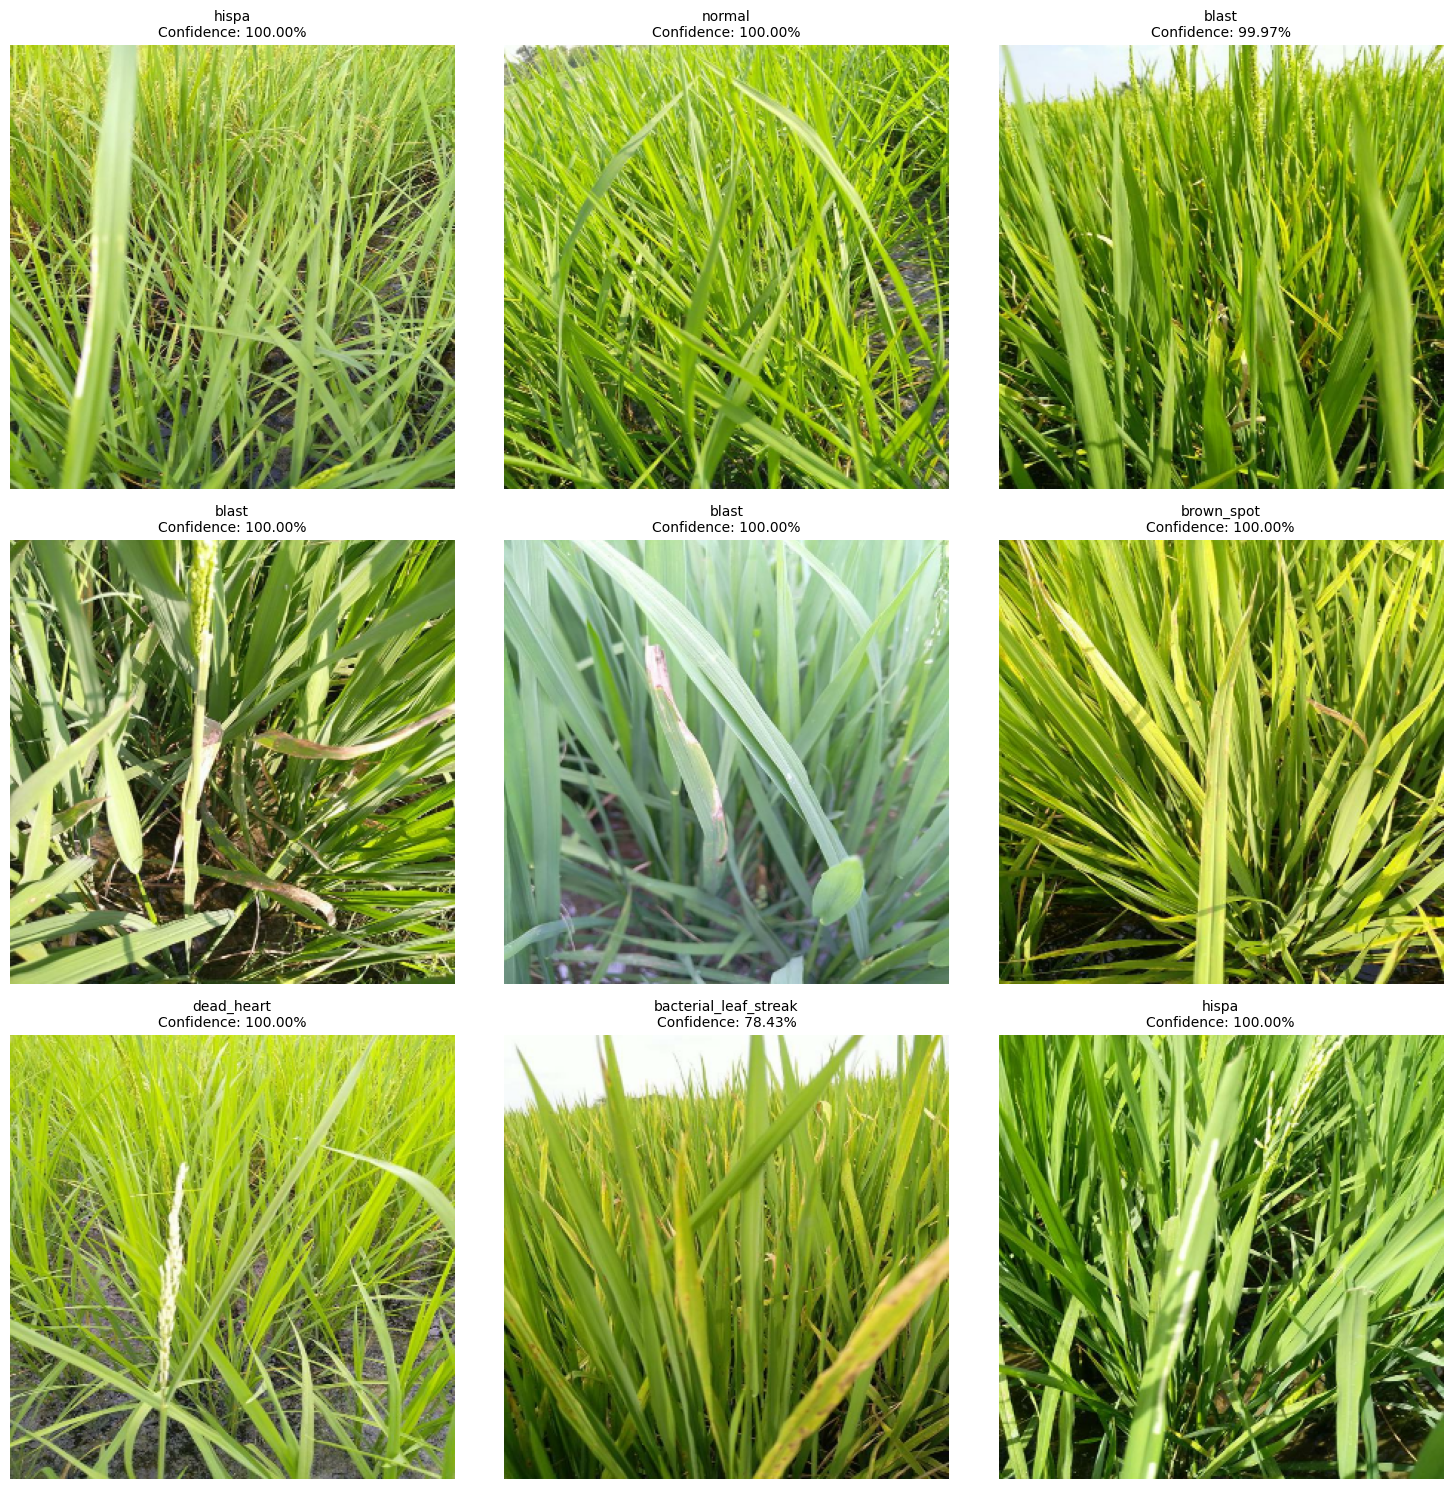

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for idx, image in enumerate(display_ds.take(9)):  # show first 9 images
    img = image[0].numpy().astype("uint8")

    pred_class = class_names[predicted_classes[idx]]
    confidence = confidence_scores[idx] * 100

    plt.subplot(3, 3, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{pred_class}\nConfidence: {confidence:.2f}%", fontsize=10)

plt.tight_layout()
plt.show()


In [26]:
pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 9.8 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 10.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.9 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 8.3 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------- ---------------------------- 2.1/7.0 MB 10.7 MB/s eta 0:00:01
   -------------------------- ------------- 4.7/7.0 MB 10.6 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 9.8 MB/s  0:0